<a href="https://colab.research.google.com/github/Mobad225/Image-Panoramas/blob/master/CV_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Uploading the images and unzipping them.

In [2]:
os.chdir('/content')
from google.colab import files
files.upload();

Saving pics.zip to pics.zip


In [0]:
!unzip -q pics.zip -d Q1_Pics

# Loading up the images into img1 & img2

In [0]:
os.chdir('/content')
path = '/Q1_Pics/'
os.chdir(os.getcwd() + path)
img1 = cv2.cvtColor(cv2.imread(os.getcwd() + '/left.jpg'), cv2.COLOR_BGR2RGB);
img2 = cv2.cvtColor(cv2.imread(os.getcwd() + '/right.jpg'), cv2.COLOR_BGR2RGB);

# Function to print photos (for testing)

In [0]:
def print_photo(data_to_show, c_style = None, single = True, title = None,
                true_size = False, pts = []):
  if true_size == True:
    #USER SCREEN DPI
    dpi, dims = 118, data_to_show.shape
    dims_inch = (dims[1]/dpi, dims[0]/dpi)
    plt.figure(figsize=dims_inch)
  plt.axis('off')
  plt.title(title)
  if len(pts) > 0:
    plt.scatter(pts[:,0], pts[:,1], color = 'b')
  if single:
    plt.imshow(data_to_show, cmap = plt.get_cmap(c_style))
    plt.show()
    plt.close()
    print()
    return
  else:
    for curr_img in data_to_show:
      plt.axis('off')
      plt.imshow(curr_img, cmap = plt.get_cmap(c_style))
      plt.show()
      plt.close()
      print()
    return

# Resize the images

In [0]:
"""
dim = img1.shape
new_dims = (dim[1]//3, dim[0]//3)
img1 = cv2.resize(img1, new_dims, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, new_dims, interpolation = cv2.INTER_AREA)
""";

# Coordinates I chose from both photos

In [6]:
print(img1.shape)

(683, 1024, 3)


In [0]:
sims_1 = np.array([(995, 901, 810, 760, 599, 965, 562),
                   (342, 339, 322, 495, 550, 423, 626)]).T
sims_2 = np.array([(540, 458, 369, 308, 139, 506, 87),
                   (325, 315, 293, 461, 513, 401, 595)]).T

In [0]:
new1 = sims_1[[5, 2, 4]]
new2 = sims_2[[5, 2, 4]]

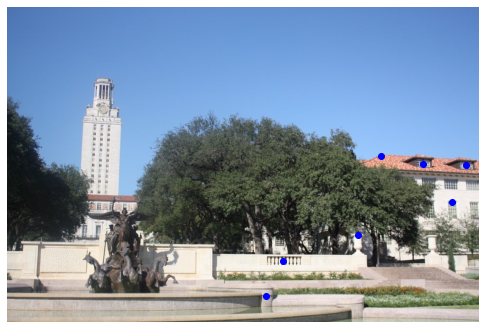

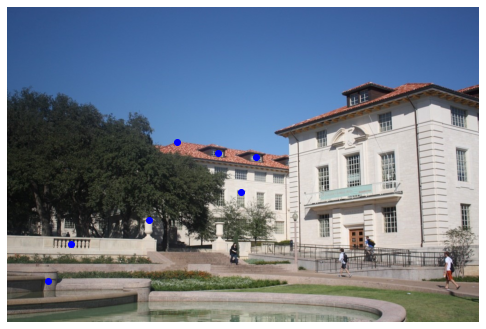

In [22]:
print_photo(img1, true_size = True, pts = sims_1)
print_photo(img2, true_size = True, pts = sims_2)

# Picking the best points.

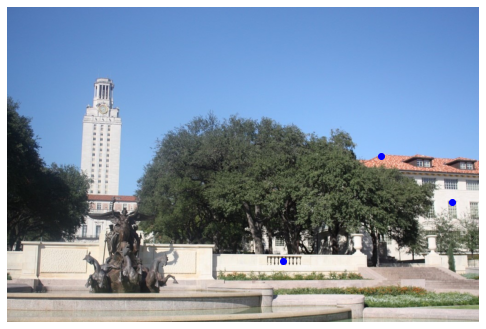

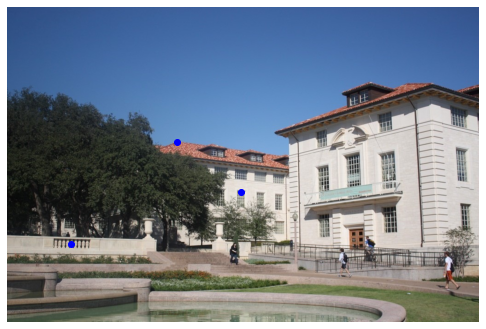

In [35]:
#best1 = sims_1[[4, 3, 2]];
#best2 = sims_2[[4, 3, 2]];
best1, best2 = new1, new2
print_photo(img1, true_size = True, pts = best1)
print_photo(img2, true_size = True, pts = best2)

# Constructing the point matrices

In [0]:
after = np.reshape(best1, (len(best1)*2, 1))
H = np.zeros((6, 6))
for i in range(6):
  curr_pt = best2[i//2]
  if i & 1 == 0:
    H[i] = np.append(curr_pt, [1, 0, 0, 0])
  else:
    H[i] = np.append(np.append([0, 0, 0], curr_pt), [1])

# Finding the degrees of freedom

In [37]:
H_inv = np.linalg.inv(H)
degrees = H_inv.dot(after)
H_mat = np.reshape(np.append(degrees, [0, 0, 1]), (3, 3))
#print(H_mat)
#degrees = np.reshape(degrees, (2,3))
print(H.dot(degrees))

[[965.]
 [423.]
 [810.]
 [322.]
 [599.]
 [550.]]


In [38]:
X = H_inv.dot(after)
print(X)

[[ 1.03470353e+00]
 [ 1.22644598e-01]
 [ 3.92259531e+02]
 [-4.37249909e-02]
 [ 9.90651146e-01]
 [ 4.78737359e+01]]


(4, 2) (4, 2)


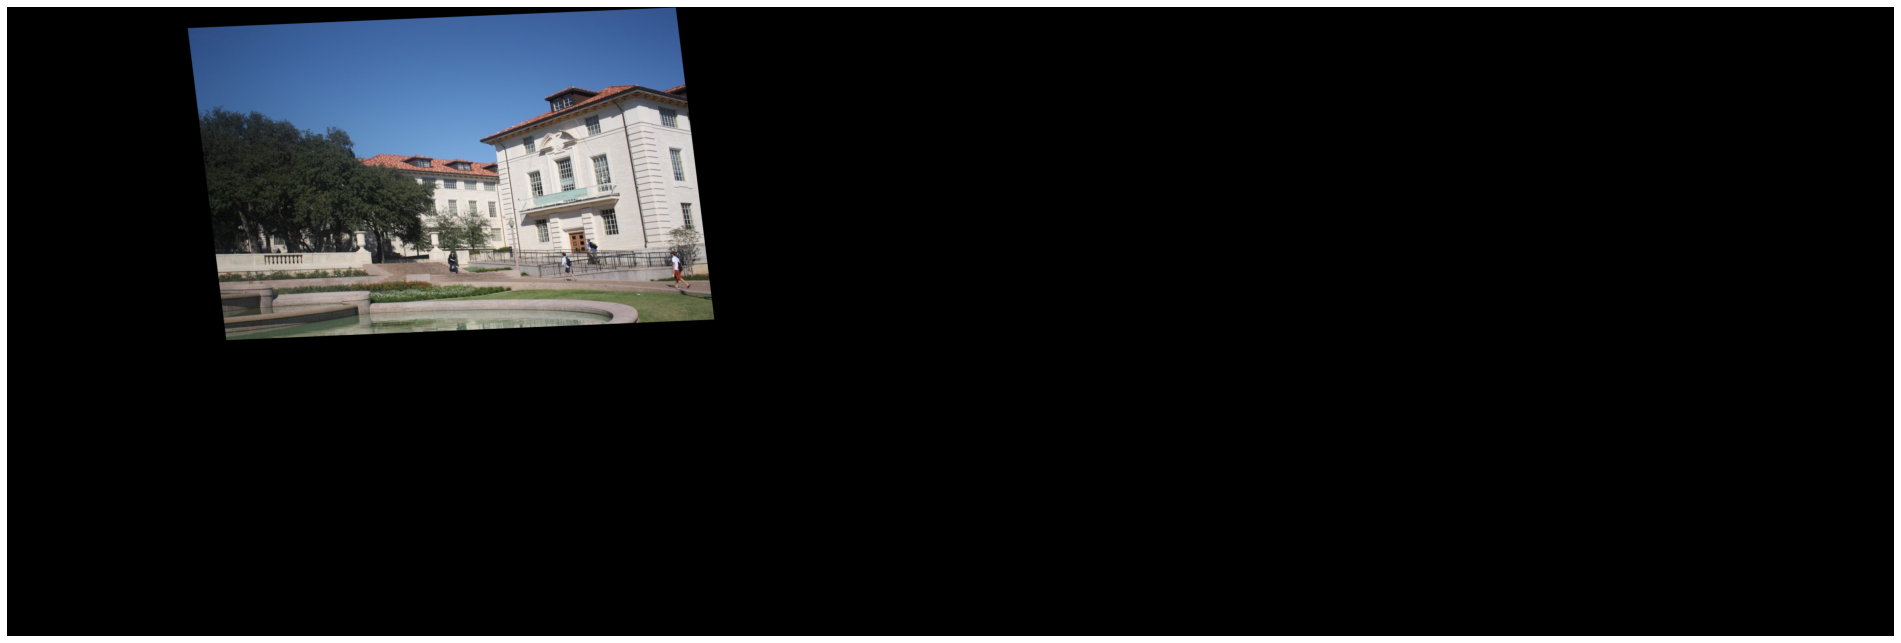

In [39]:
pts1 = np.float32(best1)
pts2 = np.float32(best2)

x1 = np.reshape(np.append(pts1, (1745, 170)), (4,2)).astype("float32")
x2 = np.reshape(np.append(pts2, (607, 210)), (4,2)).astype("float32")

print(x1.shape, x2.shape)

M = cv2.getPerspectiveTransform(x1, x2)
dst = cv2.warpPerspective(img2, H_mat,(img1.shape[1]*4, img1.shape[0]*2))
print_photo(dst, true_size = True)